In [3]:
import numpy as np
import os, glob
import open3d as o3d
import sys
from numpy import fromfile
from matplotlib import pyplot as plt 

import random
import sys
# Set the path to the mavs python api, mavs_interface.py
# you will have to change this on your system
sys.path.append(r'/home/jinhee/mavs/src/mavs_python/')
# Load the mavs python modules
import mavs_interface as mavs
import mavs_python_paths

In [4]:
sequence_num="11"

mavs_class_dict ={
    1: "rough trail",
    2: "low vegetation",
    3: "high vegetation",
    4: "smooth trail",
    5: "obstacle",    
    6: "vehicle",
    7: "dust",
    8: "stop_sign",
    9: "yield_sign",
    10: "building",
    11: "pedestrian",
    12: "fence",
    13: "pothole"
}


In [5]:
# Create the lidar and set the offset
lidar = mavs.MavsLidar('VLP-16')

In [7]:
%%time
lidar.SetOffset([0.0, 0.0, 1.2],[1.0,0.0,0.0,0.0])  #1.2

# Select a scene and load it
mavs_scenefile = '../../../../../scene_files/'+sequence_num+'/mavs_scene'+sequence_num+'_scene.json' 

# Set the path to the mavs data folder
mavs_data_path = mavs_python_paths.mavs_data_path

# Select a scene and load it
scene = mavs.MavsEmbreeScene()
scene.Load(mavs_scenefile)
scene.TurnOnLabeling()

#--- Load the waypoints that go with this scene ----#
waypoints = mavs.MavsWaypoints()
waypoints.Load('./mavs_scene'+sequence_num+'_path.vprp')
waypoints.PutWaypointsOnGround(scene)

# Create a MAVS environment and add the scene to it
env = mavs.MavsEnvironment()
env.SetScene(scene.scene)

# loop over all the poses in the waypoints list
for i in range(waypoints.num_waypoints):
    print(i)
    current_position = waypoints.GetWaypoint(i)
    current_orient = waypoints.GetOrientation(i)

    #Set pose of the lidar and scan a frame, saving labeledpoints
    lidar.SetPose(current_position,current_orient)
    lidar.Update(env,0.1)
    lidar.AnnotateFrame(env)
    lidar.AnalyzeCloud('labeled_lidar',i,False)
    lidar.SetDisplayColorType('label')
    lidar.DisplayPerspective()

    lidar.SaveProjectedLidarImage('./bmp/'+str(i).zfill(4)+'.bmp')
    lidar.SavePcd('../pcd_velodyne/'+str(i).zfill(6)+'.pcd')
    lidar.SaveLabeledPcd('./labeledpcd/labeled_lidar'+str(i).zfill(4)+'.pcd')


ERROR: mesh.cpp could not load mesh file.//mavs_scene11_surface.obj
ERROR: mesh.cpp could not load mesh file.//mavs_scene11_surface.obj


In [5]:
%%time

np_all_bins=[]
np_all_labels=[]

for file in sorted(glob.glob("./labeled*.txt")): 
    # Text file data converted to integer data type
    File_data = np.loadtxt(file, dtype=float)
    npy_file_name = "../velodyne/"+os.path.basename(file[-10:-4])+".bin"
    npy_label_file_name = "../labels/"+os.path.basename(file[-10:-4])+".label"

    np_all_bins = np.array(File_data[:,:4], dtype=np.float32)
    np_all_labels = np.array(File_data[:,4], dtype=np.uint32)

    with open(npy_file_name, 'wb') as f:
        f.write(np_all_bins)
    
    with open(npy_label_file_name, 'wb') as f:
        f.write(np_all_labels)
    
    print(f"processing {file}...")

processing ./labeled_lidar000000.txt...
processing ./labeled_lidar000001.txt...
processing ./labeled_lidar000002.txt...
processing ./labeled_lidar000003.txt...
processing ./labeled_lidar000004.txt...
processing ./labeled_lidar000005.txt...
processing ./labeled_lidar000006.txt...
processing ./labeled_lidar000007.txt...
processing ./labeled_lidar000008.txt...
processing ./labeled_lidar000009.txt...
processing ./labeled_lidar000010.txt...
processing ./labeled_lidar000011.txt...
processing ./labeled_lidar000012.txt...
processing ./labeled_lidar000013.txt...
processing ./labeled_lidar000014.txt...
processing ./labeled_lidar000015.txt...
processing ./labeled_lidar000016.txt...
processing ./labeled_lidar000017.txt...
processing ./labeled_lidar000018.txt...
processing ./labeled_lidar000019.txt...
processing ./labeled_lidar000020.txt...
processing ./labeled_lidar000021.txt...
processing ./labeled_lidar000022.txt...
processing ./labeled_lidar000023.txt...
processing ./labeled_lidar000024.txt...


In [6]:
unique, counts = np.unique(np_all_labels, return_counts=True)
print(unique, counts)
D = { y_str:count for y_str, count in zip(mavs_class_dict.values(), counts[1:])}

print(D)

[0 1 2 3 4 5] [ 4249  3470 14055  5574  1039   413]
{'rough trail': 3470, 'low vegetation': 14055, 'high vegetation': 5574, 'smooth trail': 1039, 'obstacle': 413}


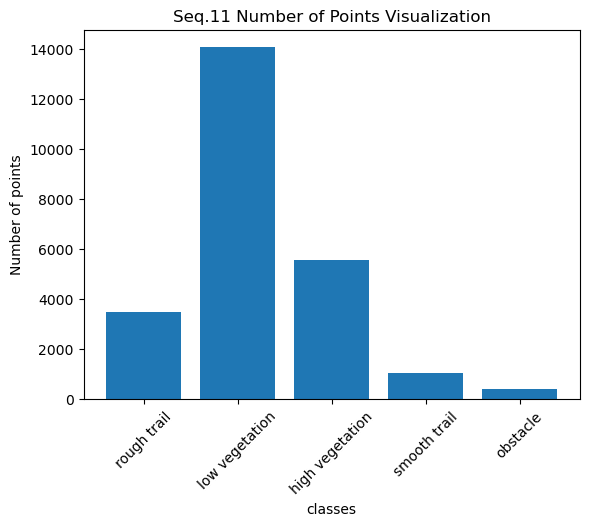

Total number of points of 11: 28800

<<Number of points according to each classes>>
 {'rough trail': 3470, 'low vegetation': 14055, 'high vegetation': 5574, 'smooth trail': 1039, 'obstacle': 413}

Seq.11: The number of the classes : 6


In [7]:
img_title="Seq."+sequence_num+" Number of Points Visualization"
num_classes = len(unique)
n_classes = len(unique)

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()),rotation = 45)
plt.xlabel('classes')
plt.ylabel('Number of points')
plt.title (img_title)

img_save_path='../meta_data/'+img_title+'.png'
plt.savefig(img_save_path, bbox_inches='tight', format="png")
plt.show()

print(f"Total number of points of {sequence_num}: {len(np_all_labels)}\n")
print(f"<<Number of points according to each classes>>\n {D}\n")
print(f"Seq.{sequence_num}: The number of the classes : {num_classes}")

with open("../meta_data/analysis.txt", "w") as f:
    print(f"Total number of points of {sequence_num}: {len(np_all_labels)}\n",file=f)
    print(f"<<Number of points according to each classes>>\n {D}\n",file=f)
    print(f"Seq.{sequence_num}: The number of the classes : {num_classes}",file=f)